In [154]:
import scipy.io as sio
import os
import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from scipy.interpolate import interp1d

import seaborn as sns
sns.set(style="whitegrid", palette="muted")

%matplotlib inline 

In [2]:
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0716'
allFiles = os.listdir(path)
treatment = filter(lambda f: 'baz1' in f, allFiles)
treatment = filter(lambda f: os.path.isdir(os.path.join(path, f)), treatment)
treatment

['less_baz1', 'less_baz1ff']

In [3]:
# read data in one position
def read_from_pos(posDir):
    fpath = os.path.join(posDir, 'data.mat')
    try:
        data = sio.loadmat(fpath)
    except:
        data = {}
    return data

In [4]:
data = read_from_pos(r'C:\YiwenShi\pengzhi\bead_binding_0907\0716\less_baz1\dish1\p1')
data['data'].dtype.names

('time',
 'ratio',
 'isgood',
 'basal',
 'delta',
 'delta_ratio',
 'dishDir',
 'posInfo',
 'posName',
 'time_2',
 'ratio_2',
 'ratio_3',
 'delta_2',
 'delta_ratio_2',
 'delta_3',
 'delta_ratio_3',
 'percent',
 'basal_2',
 'basal_3')

In [5]:
# get subfolders
# 'p\d+' for seleting position folder
# 'dish' for seleting dish folder
def get_sub_folders(dishDir, pattern):
    allFiles = os.listdir(dishDir)
    posFolders = filter(lambda f: os.path.isdir(os.path.join(dishDir, f)), allFiles)
    posFolders = filter(lambda f: bool(re.search(pattern, f)), posFolders)
    return posFolders
    

In [6]:
# reformat data for dish
def reformat_dish(dishDir):
    posFiles = get_sub_folders(dishDir, 'p\d+')
    
    time_ratio = {}
    delta_basal = []
    
    time_ratio_2 = {}
    delta_basal_2 = []
    
    time_ratio_3 = {}
    delta_basal_3 = []
    
    for pos in posFiles:
        posDir = os.path.join(dishDir, pos)
        cur_data = read_from_pos(posDir)
        if cur_data:
            # beads region
            d = [cur_data['data']['time'][0][0][0], cur_data['data']['ratio'][0][0][0]]
            df = pd.DataFrame(data=np.transpose(d), columns=['time', 'ratio'])
            time_ratio[pos] = df
            try:
                delta_basal.append(cur_data['data']['delta_ratio'][0][0][0][0])
            except:
                delta_basal = [cur_data['data']['delta_ratio'][0][0][0][0]]
            
            # non-beads region
            d_2 = [cur_data['data']['time_2'][0][0][0], cur_data['data']['ratio_2'][0][0][0]]
            df_2 = pd.DataFrame(data=np.transpose(d_2), columns=['time_2', 'ratio_2'])
            time_ratio_2[pos] = df_2
            try:
                delta_basal_2.append(cur_data['data']['delta_ratio_2'][0][0][0][0])
            except:
                delta_basal_2 = [cur_data['data']['delta_ratio_2'][0][0][0][0]]

            
            # whole cell ergion
            d_3 = [cur_data['data']['time_2'][0][0][0], cur_data['data']['ratio_3'][0][0][0]]
            df_3 = pd.DataFrame(data=np.transpose(d_3), columns=['time_2', 'ratio_3'])
            time_ratio_3[pos] = df_3
            try:
                delta_basal_3.append(cur_data['data']['delta_ratio_3'][0][0][0][0])
            except:
                delta_basal_3 = [cur_data['data']['delta_ratio_3'][0][0][0][0]]
        else:
            continue
    return time_ratio, delta_basal, time_ratio_2, delta_basal_2, time_ratio_3, delta_basal_3

## Plot for each method

In [7]:
def summary_all(path, ratio_mod, ratio_all, ratio_mod_2, ratio_all_2, ratio_mod_3, ratio_all_3):
    
    allFiles = os.listdir(path)
    method = filter(lambda f: 'baz1' in f, allFiles)
    method = filter(lambda f: os.path.isdir(os.path.join(path, f)), method)

    fig_idx = 1
    
    for item in method:
        methodDir = os.path.join(path, item)
        dishFolders = get_sub_folders(methodDir, 'dish')

        for dish in dishFolders:

            dishDir = os.path.join(methodDir, dish)
            time_ratio, delta_basal, time_ratio_2, delta_basal_2, time_ratio_3, delta_basal_3 = reformat_dish(dishDir)
            
            # beads region
            tmp = [item] * len(delta_basal)
            tmp = [np.array(tmp), delta_basal]

            df1 = pd.DataFrame(data = np.transpose(tmp), columns=['method', 'ratio'])
            ratio_mod = ratio_mod.append(df1,ignore_index=True)
            
            # non-beads region
            tmp_2 = [item] * len(delta_basal_2)
            tmp_2 = [np.array(tmp_2), delta_basal_2]

            df1_2 = pd.DataFrame(data = np.transpose(tmp_2), columns=['method', 'ratio'])
            ratio_mod_2 = ratio_mod_2.append(df1_2,ignore_index=True)
            
            # whole cell
            tmp_3 = [item] * len(delta_basal_3)
            tmp_3 = [np.array(tmp_3), delta_basal_3]

            df1_3 = pd.DataFrame(data = np.transpose(tmp_3), columns=['method', 'ratio'])
            ratio_mod_3 = ratio_mod_3.append(df1_3,ignore_index=True)

            try:
                ratio_all[item].extend(delta_basal)
            except KeyError:
                ratio_all[item] = delta_basal
            
            try:
                ratio_all_2[item].extend(delta_basal_2)
            except KeyError:
                ratio_all_2[item] = delta_basal_2
            
            try:
                ratio_all_3[item].extend(delta_basal_3)
            except KeyError:
                ratio_all_3[item] = delta_basal_3

            # plot for this dish, beads region
            plt.subplot(6, 2, fig_idx)
            for pos in time_ratio:
                plt.plot(time_ratio[pos]['time'], time_ratio[pos]['ratio'], color = 'blue')
                
            # plot for this dish, non-beads region
            plt.subplot(6, 2, fig_idx+4)
            for pos in time_ratio_2:
                plt.plot(time_ratio_2[pos]['time_2'], time_ratio_2[pos]['ratio_2'], color = 'blue')
                
            # plot for this dish, whole cell
            plt.subplot(6, 2, fig_idx+8)
            for pos in time_ratio_3:
                plt.plot(time_ratio_3[pos]['time_2'], time_ratio_3[pos]['ratio_3'], color = 'blue')
                
        fig_idx += 1
#         plt.title(item)
#         plt.xlabel('time')
#         plt.ylabel('ratio')
    return ratio_mod, ratio_mod_2, ratio_mod_3

    

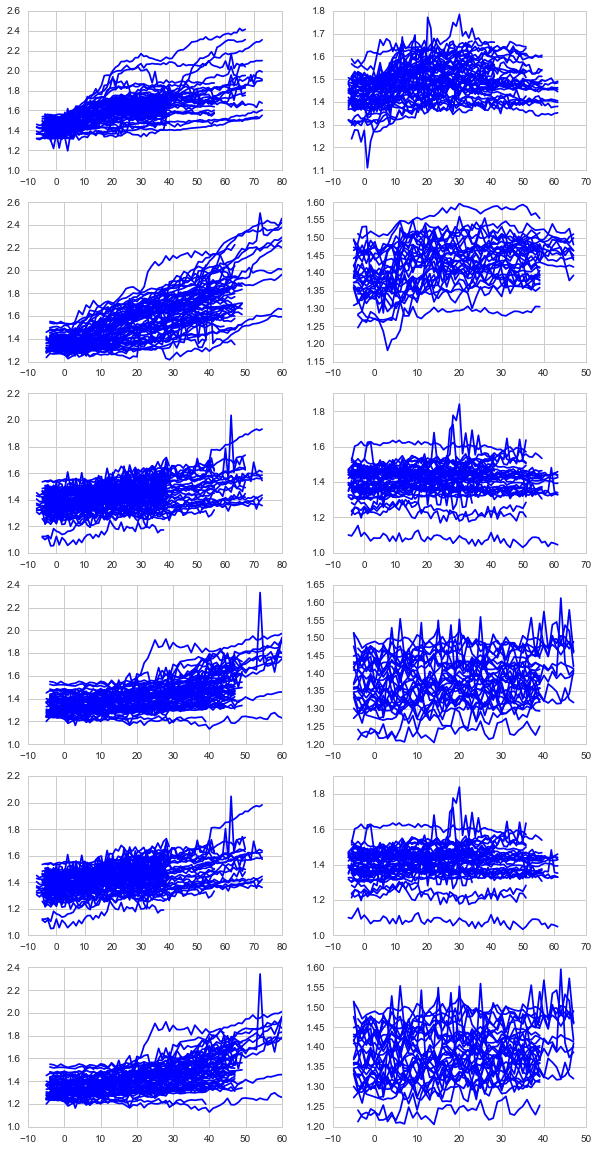

In [8]:
ratio_mod = pd.DataFrame(columns=['method', 'ratio'])
ratio_all = {}

ratio_mod_2 = pd.DataFrame(columns=['method', 'ratio'])
ratio_all_2 = {}

ratio_mod_3 = pd.DataFrame(columns=['method', 'ratio'])
ratio_all_3 = {}

plt.figure(figsize=(10,20))
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0716'
ratio_mod, ratio_mod_2, ratio_mod_3 = summary_all(path, ratio_mod, ratio_all, ratio_mod_2, ratio_all_2, ratio_mod_3, ratio_all_3)
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0820'
ratio_mod, ratio_mod_2, ratio_mod_3 = summary_all(path, ratio_mod, ratio_all, ratio_mod_2, ratio_all_2, ratio_mod_3, ratio_all_3)
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0824'
ratio_mod, ratio_mod_2, ratio_mod_3 = summary_all(path, ratio_mod, ratio_all, ratio_mod_2, ratio_all_2, ratio_mod_3, ratio_all_3)

plt.show()


## Average for each method

In [41]:
ratio_all = pd.DataFrame.from_dict(ratio_all, orient='index')
ratio_all = ratio_all.transpose()

ratio_all_2 = pd.DataFrame.from_dict(ratio_all_2, orient='index')
ratio_all_2 = ratio_all_2.transpose()

ratio_all_3 = pd.DataFrame.from_dict(ratio_all_3, orient='index')
ratio_all_3 = ratio_all_3.transpose()
# mean_ratio = np.mean(ratio_all)

In [42]:
mean_ratio = np.mean(ratio_all)
print mean_ratio

mean_ratio_2 = np.mean(ratio_all_2)
print mean_ratio_2

mean_ratio_3 = np.mean(ratio_all_3)
print mean_ratio_3

fl_baz1ff      0.104869
less_baz1      0.349750
less_baz1ff    0.067955
fl_baz1        0.168453
dtype: float64
fl_baz1ff      0.060490
less_baz1      0.169029
less_baz1ff    0.043770
fl_baz1        0.090466
dtype: float64
fl_baz1ff      0.064322
less_baz1      0.182266
less_baz1ff    0.044601
fl_baz1        0.095707
dtype: float64


In [43]:
mean_list = [mean_ratio['less_baz1'], mean_ratio['less_baz1ff'],mean_ratio['fl_baz1'], mean_ratio['fl_baz1ff']]
print mean_list

mean_list_2 = [mean_ratio_2['less_baz1'], mean_ratio_2['less_baz1ff'],mean_ratio_2['fl_baz1'], mean_ratio_2['fl_baz1ff']]
print mean_list_2

mean_list_3 = [mean_ratio_3['less_baz1'], mean_ratio_3['less_baz1ff'],mean_ratio_3['fl_baz1'], mean_ratio_3['fl_baz1ff']]
print mean_list_3

[0.34975006744984283, 0.067954636538678406, 0.16845320025193275, 0.10486908140704422]
[0.16902872149746853, 0.043770382596947786, 0.090465840434236458, 0.060489658668463946]
[0.18226629154203694, 0.044601325425043761, 0.095707036368394865, 0.06432187942296784]



## Summary for each method

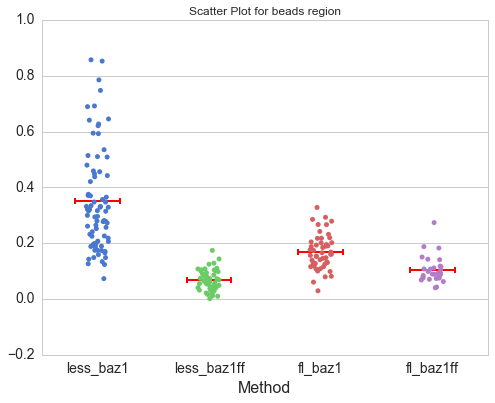

In [44]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, frame_on=True)
sns.stripplot(x="method", y="ratio", data=ratio_mod, jitter=True);

linecolor = 'red'
X = range(len(mean_ratio))

plt.errorbar(X, mean_list, xerr = 0.2, linestyle='None',\
             color=linecolor, markersize='10', ecolor=linecolor,zorder=2,linewidth=2,\
             capthick=2)

plt.title('Scatter Plot for beads region')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(' ', fontsize=16)
plt.xlabel('Method', fontsize=16)

# plt.grid(False)


# # fig.spines['left'].set_position('center')
# ax.spines['left'].set_color('black')
# ax.spines['left'].set_linewidth(2)

# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_color('black')
# ax.spines['bottom'].set_linewidth(2)
# ax.spines['top'].set_color('none')

plt.savefig('beads_scatter.png')
plt.show()



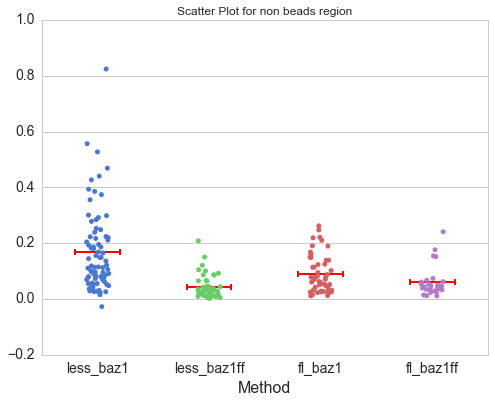

In [45]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, frame_on=True)
sns.stripplot(x="method", y="ratio", data=ratio_mod_2, jitter=True);

linecolor = 'red'
X = range(len(mean_ratio_2))

plt.errorbar(X, mean_list_2, xerr = 0.2, linestyle='None',\
             color=linecolor, markersize='10', ecolor=linecolor,zorder=2,linewidth=2,\
             capthick=2)

plt.title('Scatter Plot for non beads region')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(' ', fontsize=16)
plt.xlabel('Method', fontsize=16)

# plt.grid(False)


# # fig.spines['left'].set_position('center')
# ax.spines['left'].set_color('black')
# ax.spines['left'].set_linewidth(2)

# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_color('black')
# ax.spines['bottom'].set_linewidth(2)
# ax.spines['top'].set_color('none')

plt.savefig('non_beads_scatter.png')
plt.show()

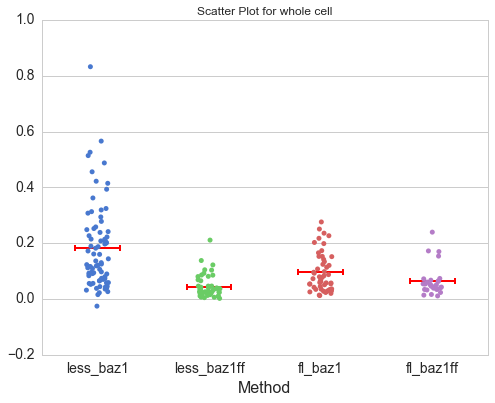

In [46]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, frame_on=True)
sns.stripplot(x="method", y="ratio", data=ratio_mod_3, jitter=True);

linecolor = 'red'
X = range(len(mean_ratio_3))

plt.errorbar(X, mean_list_3, xerr = 0.2, linestyle='None',\
             color=linecolor, markersize='10', ecolor=linecolor,zorder=2,linewidth=2,\
             capthick=2)

plt.title('Scatter Plot for whole cell')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(' ', fontsize=16)
plt.xlabel('Method', fontsize=16)

# plt.grid(False)


# # fig.spines['left'].set_position('center')
# ax.spines['left'].set_color('black')
# ax.spines['left'].set_linewidth(2)

# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_color('black')
# ax.spines['bottom'].set_linewidth(2)
# ax.spines['top'].set_color('none')

plt.savefig('whole_cell_scatter.png')
plt.show()

In [53]:
ratio_mod.to_csv('0907_beads_data.csv')
ratio_mod_2.to_csv('0907_non_beads_data.csv')
ratio_mod_3.to_csv('0907_whole_cell_data.csv')

## Average for each dish & summary

### Dish data manipulation
* Interpolate data in each position to fill in nan data
* Take average of all data in same dish

### Plot each dish using same method in same figure

In [171]:
def my_interp(d, tag):
    # exact index of ratio value, -10 as 0 and 109 as 110 
    try:
        idx = d['time']+10
    except:
        idx = d['time_2']+10
    idx = idx.astype(int)

    # initialize tmp for storing ratio 
    tmp = np.empty((1, 110))
    tmp[:] = np.NAN
    
    if tag == 1:
        tmp[:, idx] = d['ratio']
    else:
        try:
            tmp[:, idx] = d['ratio']
        except:
            if tag == 2:
                tmp[:, idx] = d['ratio_2'] 
            elif tag == 3:
                tmp[:, idx] = d['ratio_3'] 
            


    # index of first and last ratio value 
    i1 = idx.iloc[0]
    i2 = idx.iloc[-1]

    cur_data = tmp[:, i1:i2][0]

    # interpolate data to fill in missing data 
    not_nan = np.logical_not(np.isnan(cur_data))
    indices = np.arange(len(cur_data))

    data_interp = np.interp(indices, indices[not_nan], cur_data[not_nan])
    cur_data[~not_nan] = data_interp[~not_nan]
    tmp[:, i1:i2][0] = cur_data
    
    return tmp

In [238]:
def data_integration(path, avg_method_beads, avg_method_no_beads, avg_method_all_region):
    
    allFiles = os.listdir(path)
    method = filter(lambda f: 'baz1' in f, allFiles)
    method = filter(lambda f: os.path.isdir(os.path.join(path, f)), method)

    fig_idx = 1
    
    for item in method:
        methodDir = os.path.join(path, item)
        dishFolders = get_sub_folders(methodDir, 'dish')
        
        avg_beads = []
        avg_no_beads = []
        avg_all_region = []
        
        for dish in dishFolders:
            # summary in each dish
            # data integration 
            dishDir = os.path.join(methodDir, dish)
            time_ratio, delta_basal, time_ratio_2, delta_basal_2, time_ratio_3, delta_basal_3 = reformat_dish(dishDir)
            
            beads_tmp = []
            no_beads_tmp = []
            all_region_tmp = []
            
            # beads region
            for p, d in time_ratio.items():
                
                tmp = my_interp(d, 1)
                
                # store ratio value into a table 
                try:
                    beads_tmp = np.vstack([beads_tmp, tmp])
                except:
                    beads_tmp = tmp
                                
            # no beads region
            for p, d in time_ratio_2.items():
                
                tmp = my_interp(d, 2)
                
                # store ratio value into a table 
                try:
                    no_beads_tmp = np.vstack([no_beads_tmp, tmp])
                except:
                    no_beads_tmp = tmp
                    
            # all region
            for p, d in time_ratio_3.items():
                
                my_interp(d, 3)
                
                # store ratio value into a table 
                try:
                    all_region_tmp = np.vstack([all_region_tmp, tmp])
                except:
                    all_region_tmp = tmp
            
            # take average of current dish and store 
            try:
                avg_beads = np.vstack([avg_beads, np.mean(beads_tmp, axis=0)])
            except:
                avg_beads = np.mean(beads_tmp, axis=0)
                
            try:
                avg_no_beads = np.vstack([avg_no_beads, np.mean(no_beads_tmp, axis=0)])
            except:
                avg_no_beads = np.mean(no_beads_tmp, axis=0)
                
            try:
                avg_all_region = np.vstack([avg_all_region, np.mean(all_region_tmp, axis=0)])
            except:
                avg_all_region = np.mean(all_region_tmp, axis=0)
        
        # average of each dish using specific method 
        try:
            avg_method_beads[item] = np.vstack([avg_method_beads[item], avg_beads])
        except:
            avg_method_beads[item] = avg_beads
            
        try:
            avg_method_no_beads[item] = np.vstack([avg_method_no_beads[item], avg_no_beads])
        except:
            avg_method_no_beads[item] = avg_no_beads
            
        try:
            avg_method_all_region[item] = np.vstack([avg_method_all_region[item], avg_all_region])
        except:
            avg_method_all_region[item] = avg_all_region
    
    return avg_method_beads, avg_method_no_beads, avg_method_all_region



In [239]:
avg_method_beads = {} 
avg_method_no_beads = {}
avg_method_all_region = {}

path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0716'
avg_method_beads, avg_method_no_beads, avg_method_all_region = \
    data_integration(path, avg_method_beads, avg_method_no_beads, avg_method_all_region)
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0820'
avg_method_beads, avg_method_no_beads, avg_method_all_region = \
    data_integration(path, avg_method_beads, avg_method_no_beads, avg_method_all_region)
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0824'
avg_method_beads, avg_method_no_beads, avg_method_all_region = \
    data_integration(path, avg_method_beads, avg_method_no_beads, avg_method_all_region)

In [235]:
avg_method_beads.keys()

['fl_baz1ff', 'less_baz1', 'less_baz1ff', 'fl_baz1']

In [278]:
time = np.arange(0, 110) - 10

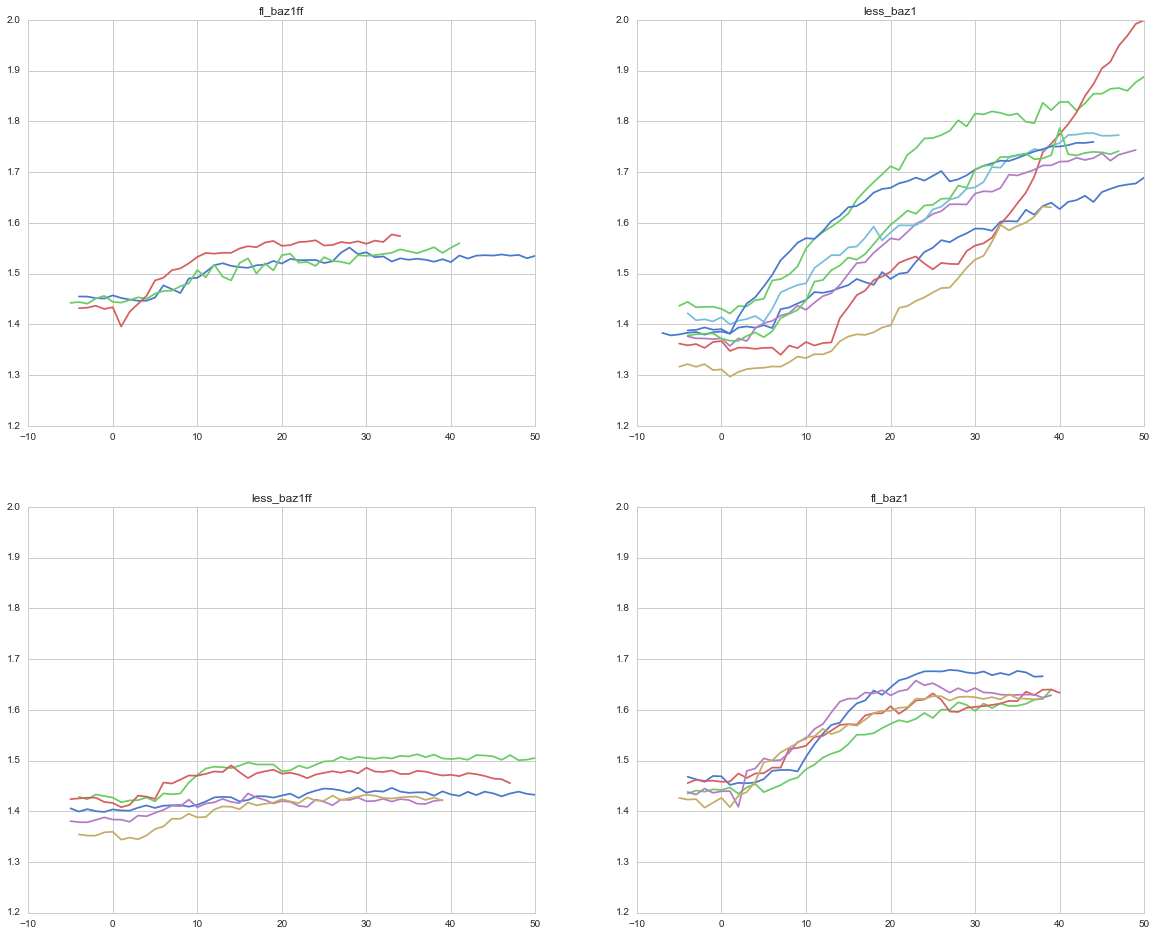

In [280]:
fig = plt.figure(figsize=(20, 16)) 

ax1 = plt.subplot(221)
plt.plot(time, avg_method_beads['fl_baz1ff'].T)
plt.title('fl_baz1ff')

ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)
plt.plot(time, avg_method_beads['less_baz1'].T)
plt.title('less_baz1')

ax3 = plt.subplot(223, sharex=ax1, sharey=ax1)
plt.plot(time, avg_method_beads['less_baz1ff'].T)
plt.title('less_baz1ff')

ax4 = plt.subplot(224, sharex=ax1, sharey=ax1)
plt.plot(time, avg_method_beads['fl_baz1'].T)
plt.title('fl_baz1')

# adjust range of plot
plt.xlim([-10, 50])
plt.ylim([1.2, 2.0])

plt.savefig('avg_0907.png')
plt.show()
